# Standard pipeline: analyzing 5K PBMC dataset from 10X genomics


## Introduction <a name="introduction"></a>

In this tutorial we will analyze single-cell ATAC-seq data from Peripheral blood mononuclear cells (PBMCs).

## Import library and environment setup <a name="setup"></a>

In [1]:
import snapatac2 as snap

snap.__version__

'2.3.0.dev3'

Download the fragment file.

In [2]:
# Input files
fragment_file = snap.datasets.pbmc5k()
fragment_file

PosixPath('/home/kaizhang/.cache/snapatac2/atac_pbmc_5k.tsv.gz')

## Preprocessing <a name="preprocessing"></a>

We begin data preprocessing by importing fragment files and calculating the quality control (QC) metric using the `pp.import_data` function.

This function generates genome-wide TN5 insertion counts and stores the results in an AnnData object (To learn more about SnapATAC2's anndata implementation, click [here](https://kzhang.org/epigenomics-analysis/anndata.html)). Throughout this process, various quality control measures, such as TSS enrichment and the number of unique fragments per cell, are computed and stored in the anndata.

When the `file` argument is not specified, the AnnData object is created and stored in the computer's memory. However, if the `file` argument is provided, the AnnData object will be backed by an hdf5 file. In "backed" mode, `pp.import_data` processes the data in chunks and streams the results to the disk, using only a small, fixed amount of memory. Therefore, it is recommended to specify the `file` parameter when working with large datasets and limited memory resources. Keep in mind that analyzing data in "backed" mode is slightly slower than in "memory" mode.

In this tutorial we will use the backed mode. To learn more about the differences between these two modes, click [here](https://kzhang.org/epigenomics-analysis/anndata.html).

In [3]:
%%time
data = snap.pp.import_data(
    fragment_file,
    genome=snap.genome.hg38,
    file="pbmc.h5ad",  # Optional
    sorted_by_barcode=False,
)
data

CPU times: user 11min 31s, sys: 17.5 s, total: 11min 49s
Wall time: 3min 22s


AnnData object with n_obs x n_vars = 14227 x 0 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

To identify usable/high-quality cells, we can plot TSS enrichment against number of unique fragments for each cell.

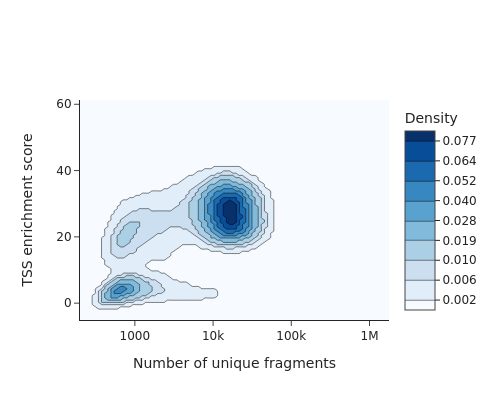

In [4]:
snap.pl.tsse(data, interactive=False)

The cells in the upper right represent valid or high-quality cells, whereas those in the lower left represent low-quality cells or empty droplets. Based on this plot, we decided to set a minimum TSS enrichment of 10 and a minimum number of fragments of 5,000 to filter the cells.

In [5]:
%%time
snap.pp.filter_cells(data, min_counts=5000, min_tsse=10, max_counts=100000)
data

CPU times: user 15.3 s, sys: 1.3 s, total: 16.6 s
Wall time: 17.5 s


AnnData object with n_obs x n_vars = 4564 x 0 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

We next create a cell by bin matrix containing insertion counts across genome-wide 500-bp bins.

In [6]:
%%time
snap.pp.add_tile_matrix(data)

CPU times: user 1min 3s, sys: 2.18 s, total: 1min 5s
Wall time: 19.4 s


Next, we perform feature selection using `pp.select_features`. The result is stored in `data.var['selected']` and will be automatically utilized by relevant functions such as `pp.scrublet` and `tl.spectral`.

The default feature selection algorithm chooses the most accessible features. The `n_features` parameter determines the number of features or bins used in subsequent analysis steps. Generally, including more features improves resolution and reveals finer details, but it may also introduce noise. To optimize results, experiment with the `n_features` parameter to find the most appropriate value for your specific dataset.

Additionally, you can provide a filter list to the function, such as a blacklist or whitelist. For example, use `pp.select_features(data, blacklist='blacklist.bed')`.

In [7]:
snap.pp.select_features(data, n_features=250000)

2023-04-09 11:50:52 - INFO - Selected 250000 features.


### Doublet removal

Here we apply a customized scrublet algorithm to identify potential doublets. Calling `pp.scrublet` will assign probabilites of being doublets to the cells. We can then use `pp.filter_doublets` to get the rid of the doublets.

In [8]:
%%time
snap.pp.scrublet(data)

CPU times: user 4min 37s, sys: 11.5 s, total: 4min 48s
Wall time: 1min 23s


This line does the actual filtering.

In [9]:
snap.pp.filter_doublets(data)
data

2023-04-09 11:52:16 - INFO - Detected doublet rate = 2.805%


AnnData object with n_obs x n_vars = 4436 x 6062095 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'scrublet_sim_doublet_score'
    obsm: 'insertion'

## Dimenstion reduction <a name="dimension_reduction"></a>

To calculate the lower-dimensional representation of single-cell chromatin profiles, we employ spectral embedding for dimensionality reduction. The resulting data is stored in `data.obsm['X_spectral']`. Comprehensive information about the dimension reduction algorithm we utilize can be found in the [algorithm documentation](https://kzhang.org/epigenomics-analysis/dim_reduct.html).

In [10]:
%%time
snap.tl.spectral(data)

CPU times: user 1min 9s, sys: 2.56 s, total: 1min 11s
Wall time: 31.5 s


We then use UMAP to embed the cells to 2-dimension space for visualization purpose. This step will have to be run after `snap.tl.spectral` as it uses the lower dimesnional representation created by the spectral embedding.

In [11]:
%%time
snap.tl.umap(data)

CPU times: user 2min 9s, sys: 4.73 s, total: 2min 14s
Wall time: 1min 53s


## Clustering analysis <a name="clustering"></a>

We next perform graph-based clustering to identify cell clusters. We first build a k-nearest neighbour graph using `snap.pp.knn`, and then use the Leiden community detection algorithm to identify densely-connected subgraphs/clusters in the graph.

In [12]:
%%time
snap.pp.knn(data)
snap.tl.leiden(data)

CPU times: user 4.24 s, sys: 110 ms, total: 4.35 s
Wall time: 1.51 s


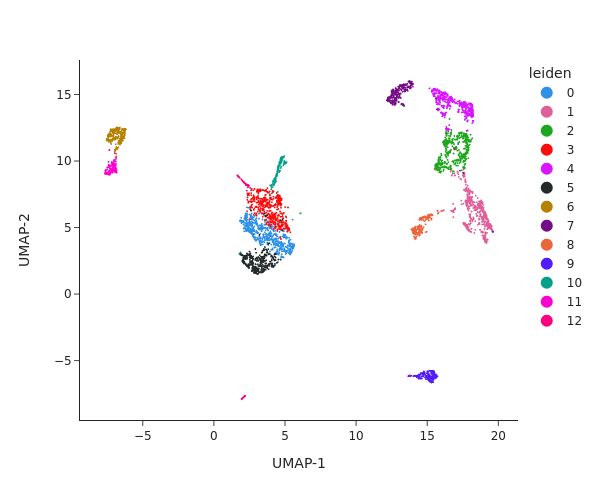

In [13]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

## Cell cluster annotation <a name="annotation"></a>

### Create the cell by gene activity matrix

Now that we have the cell clusters, we will try to annotate the clusters and assign them to known cell types. To do this, we need to compute the gene activities first for each cell using the `pp.make_gene_matrix` function.

Just like `pp.import_data`, `pp.make_gene_matrix` allows you to provide an optional file name used to store the AnnData object. To demo the in-memory mode of AnnData, we will not provide the `file` parameter this time.

In [14]:
%%time
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38)
gene_matrix

/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



CPU times: user 3min 24s, sys: 1.89 s, total: 3min 26s
Wall time: 24.5 s


AnnData object with n_obs × n_vars = 4436 × 60606
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden'

### Imputation

The cell by gene activity matrix is usually very sparse. To ease the visulization and marker gene identification, we use the MAGIC algorithm to perform imputation and data smoothing. The subsequent steps are similar to those in single-cell RNA-seq analysis, we therefore leverage the [scanpy](https://scanpy.readthedocs.io/en/stable/) package to do this.

Since we have stored the gene matrix in in-memory mode, we can directly pass it to scanpy. If the AnnData object is in backed mode, you need to convert it to an in-memory representation using the `.to_memory()` method.

We first perform gene filtering, data normalization, data transformation, and then call the `sc.external.pp.magic` function to complete the imputation.

In [15]:
import scanpy as sc

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

In [16]:
%%time
sc.external.pp.magic(gene_matrix, solver="approximate")

/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/magic/utils.py:145: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



CPU times: user 1min 12s, sys: 3.46 s, total: 1min 16s
Wall time: 41.4 s


In [17]:
# Copy over UMAP embedding
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

We can now visualize the gene activity of a few marker genes.

/projects/ps-renlab2/kai/software/micromamba/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



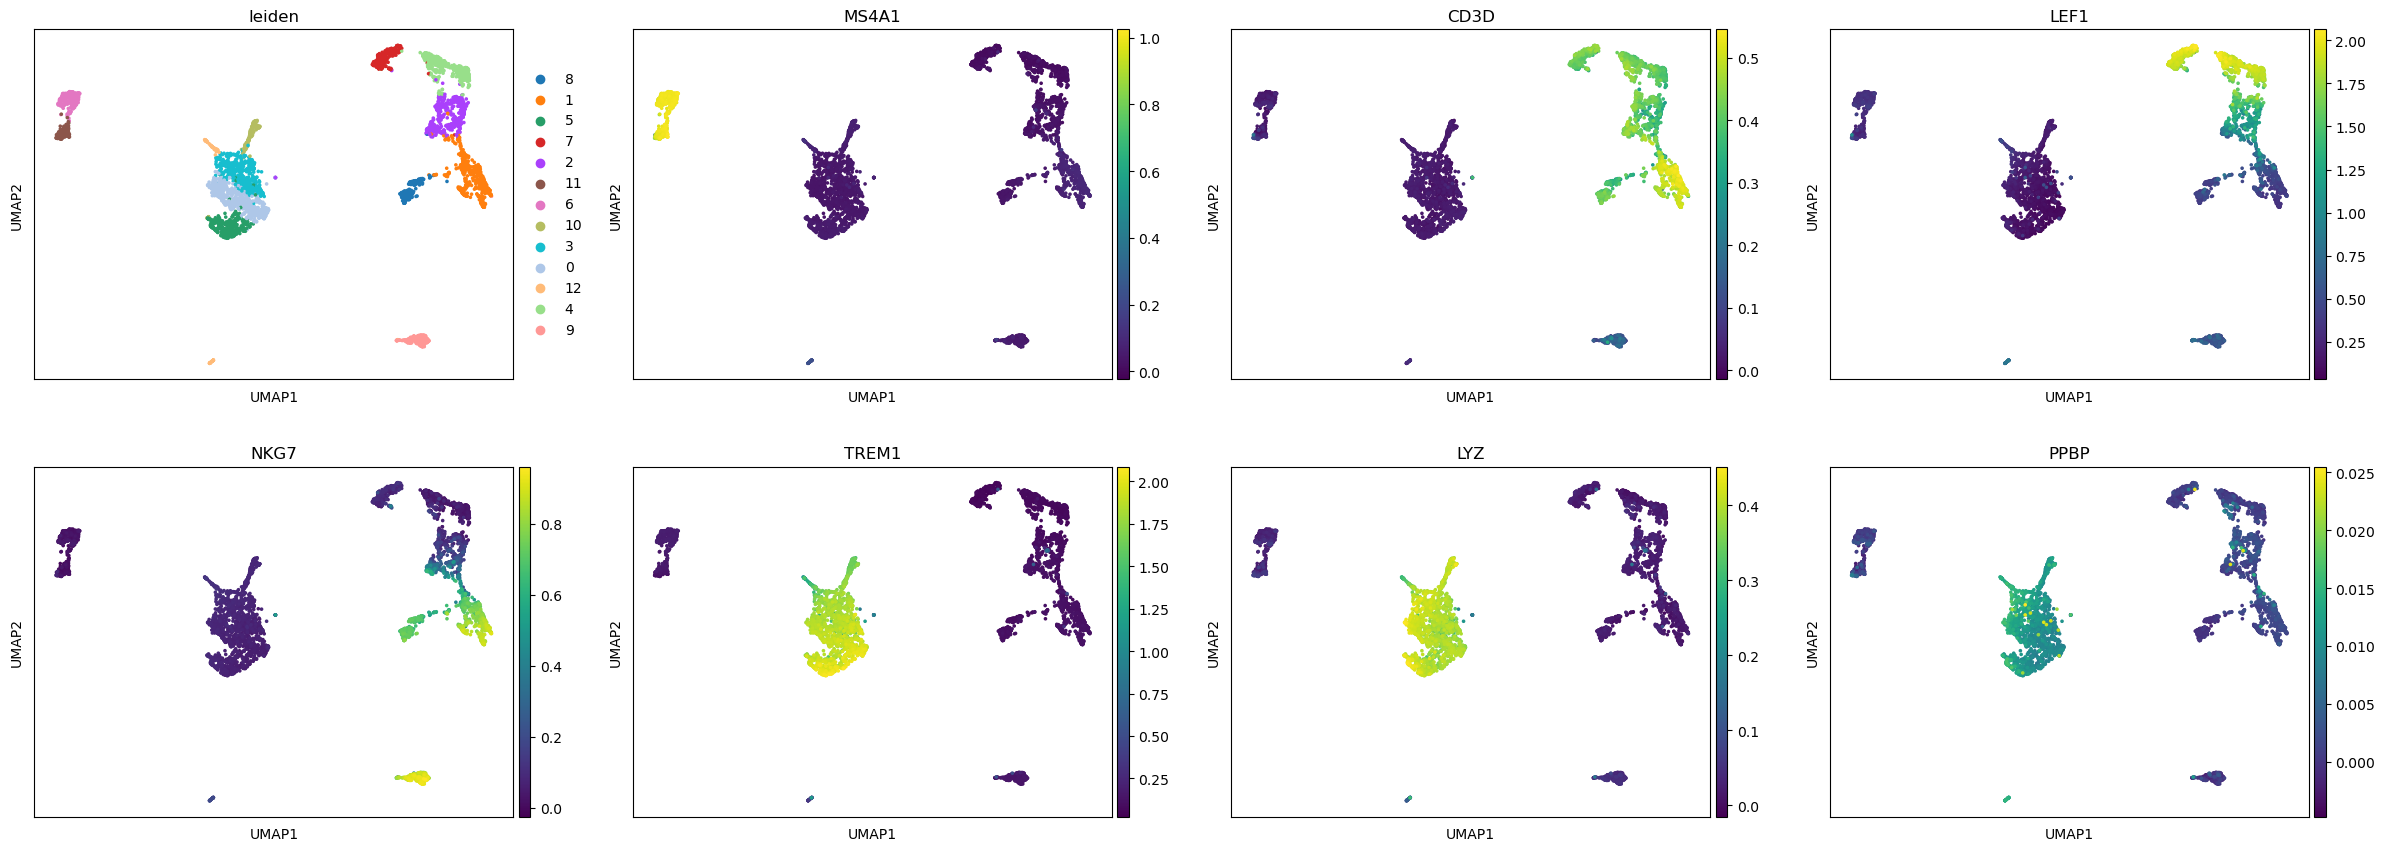

In [18]:
marker_genes = ['MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ', 'PPBP']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes)

### Close AnnData objects

When the AnnData objects are opened in backed mode, they will be synchronized with the underlying HDF5 files, which means there is no need to manually save the results during the analysis and the files are always up to date. As a side effect, **it is important to close every backed AnnData object before shutdown the Python process to avoid HDF5 file corruptions!**

In [19]:
data.close()
data

Closed AnnData object

Also, remember to save any in-memory AnnData objects.

In [20]:
gene_matrix.write("pbmc5k_gene_mat.h5ad", compression='gzip')

Now it is safe to close and shutdown the notebook! Next time you can load the results using `data = snap.read("pbmc.h5ad")`.

## What's next?

- [Cell type annotation](https://kzhang.org/SnapATAC2/tutorials/annotation.html)
- [Differential peak and motif analysis](https://kzhang.org/SnapATAC2/tutorials/diff.html)